===========**Training ACCURACY**================
Epoch 100
Training Accuracy:  0.86
Training Loss: 0.456427
Total Training Loss: 4.20585
iteration:0===========**VALIDATION ACCURACY**================
Epoch:100
Validation Accuracy:  0.86
Validation Loss: 0.470227
Total Validation Loss: 4.21962
Time Elapsed for Epoch:100 is 0.337106815974 minutes


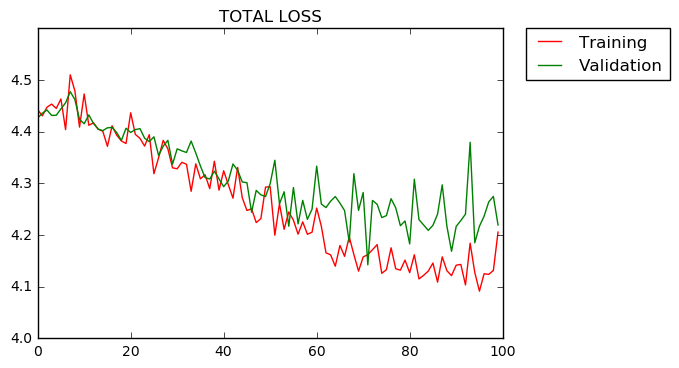

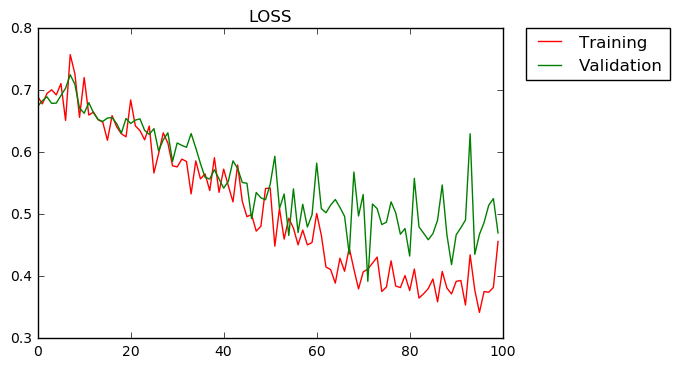

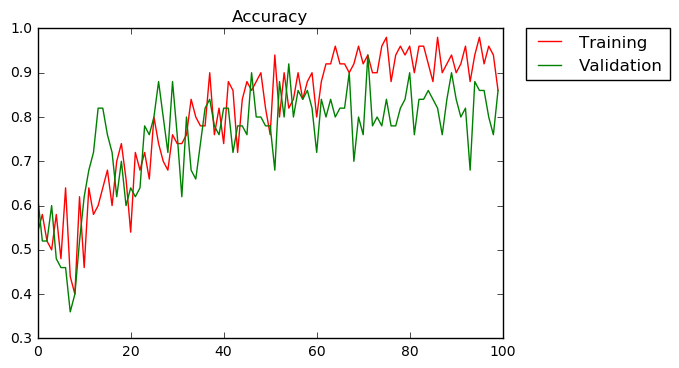

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import vgg16_modified as vgg16
import os
import time
import numpy as np
from IPython.display import clear_output
import sys
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
PRETRAINED_MODEL_PATH= "/home/sik4hi/ckpt_dir"
N_EPOCHS = 100
INIT_LEARNING_RATE = 0.001
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 100
N_CLASSES = 1000
DROPOUT = 0.50
NUM_GPUS=2
ckpt_dir = "/home/sik4hi/ckpt_dir"
LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH0 = '/mnt/data1/imagenet-data/csv-files/train2/imagenetdata0.csv'
TRAINSET_PATH1 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata1.csv'
TRAINSET_PATH2 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata2.csv'
TRAINSET_PATH3 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata3.csv'
TRAINSET_PATH4 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata4.csv'
TRAINSET_PATH5 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata5.csv'
TRAINSET_PATH6 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata6.csv'
TRAINSET_PATH7 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata7.csv'
TRAINSET_PATH8 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata8.csv'
TRAINSET_PATH9 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata9.csv'

VALSET_PATH0 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata100-0.csv'
VALSET_PATH1 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata1.csv'
VALSET_PATH2 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata2.csv'
VALSET_PATH3 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata3.csv'
VALSET_PATH4 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata4.csv'


def _tower_loss(images, labels,train_mode, scope):
    # Build inference Graph.
    
    vgg = vgg16.Vgg16()
    vgg.build(images, train_mode)
    weights_only = filter(lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    for x in xrange(len(weights_only)):
        print (weights_only[x].name)
    # print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print vgg.get_var_count()
    
    # Build the portion of the Graph calculating the losses. Note that we will
    # assemble the total_loss using a custom function below.
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.prob, labels), name='loss_tf')
    #loss_summary = tf.summary.scalar("loss", loss_tf)
    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    weight_decay = tf.reduce_mean(tf.add_n([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
    total_loss = loss_tf + weight_decay
    
    correct_pred = tf.equal(tf.argmax(vgg.prob, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return total_loss,loss_tf, accuracy


def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
        # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(0,grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

def _compute_longer_edge(height, width, new_shorter_edge):
    return tf.cast(width*new_shorter_edge/height, tf.int32)
    
def train():
    """Train CIFAR-10 for a number of steps."""
    with tf.Graph().as_default(), tf.device('/cpu:0'):
        learning_rate = tf.placeholder(tf.float32, [])
        images_tf = tf.placeholder(tf.float32, [BATCH_SIZE, 224, 224, 3])
        labels_tf = tf.placeholder(tf.int64,[BATCH_SIZE])
        train_mode = tf.placeholder(tf.bool)
        
        opt = tf.train.MomentumOptimizer(INIT_LEARNING_RATE,MOMENTUM)
       
        csv_path = tf.train.string_input_producer([VALSET_PATH0], shuffle=True)
        textReader = tf.TextLineReader()
        _,csv_content = textReader.read(csv_path)
        im_name, im_label = tf.decode_csv(csv_content, record_defaults=[[""], [1]])

        im_content = tf.read_file(im_name)
        train_image = tf.image.decode_jpeg(im_content, channels=3)
        train_image = tf.cast(train_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
        # train_image = augment(train_image)
        size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
        train_image = tf.image.resize_images(train_image, size)
        train_label = tf.cast(im_label, tf.int64) # unnecessary
        train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                                      capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

        
        
        val_csv_path = tf.train.string_input_producer([VALSET_PATH0
                                                      # , VALSET_PATH1,
                                                      # VALSET_PATH2, VALSET_PATH3, 
                                                      # VALSET_PATH4
                                                      ], shuffle=True)
        val_textReader = tf.TextLineReader()
        _, val_content = val_textReader.read(val_csv_path)
        val_image, val_label = tf.decode_csv(val_content, record_defaults=[[""], [1]])

        val_image_content = tf.read_file(val_image)
        val_image = tf.image.decode_jpeg(val_image_content, channels=3)
    

        shape = tf.shape(val_image)
        height = shape[0]
        width = shape[1]
        new_shorter_edge = tf.constant(256, dtype=tf.int32)
        height_smaller_than_width = tf.less_equal(height, width)
        new_height_and_width = tf.cond(height_smaller_than_width,
                                       lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
                                       lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
                                      )
        size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
        val_image = tf.image.resize_images(val_image, size)
        size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
        val_image = tf.random_crop(val_image, size)
        #val_image = tf.image.random_flip_left_right(val_image)
        val_image = tf.cast(val_image, tf.float32) / 255. # necessary


        val_label = tf.cast(val_label, tf.int64) # unnecessary
        val_image_batch, val_label_batch = tf.train.shuffle_batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)
        
        images_splits = tf.split(0, NUM_GPUS, images_tf)
        labels_splits = tf.split(0, NUM_GPUS, labels_tf)
        
        # Calculate the gradients for each model tower.
        tower_grads = []
        tower_accuracy = []
        for i in xrange(NUM_GPUS):
            with tf.device('/gpu:%d' % i):
                with tf.name_scope('%s_%d' % ('tower', i)) as scope:
                    # Calculate the loss for one tower of the CIFAR model. This function
                    # constructs the entire CIFAR model but shares the variables across
                    # all towers.
                    
                    loss_tf2, loss_tf, accuracy  = _tower_loss(images_splits[i], labels_splits[i],train_mode, scope)
                    # Reuse variables for the next tower.
                    tf.get_variable_scope().reuse_variables()

                    # Retain the summaries from the final tower.
                    # summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

                    # Calculate the gradients for the batch of data on this CIFAR tower.
                    grads = opt.compute_gradients(loss_tf2)
                    
                    # Keep track of the gradients across all towers.
                    tower_grads.append(grads)
                    tower_accuracy.append(accuracy)
        # We must calculate the mean of each gradient. Note that this is the
        # synchronization point across all towers.
        grads = average_gradients(tower_grads)
        total_accuracy=tf.reduce_mean(tower_accuracy)
        # Add a summary to track the learning rate.
        # summaries.append(tf.contrib.deprecated.scalar_summary('learning_rate', lr))

        # Add histograms for gradients.
        #for grad, var in grads:
        #      if grad is not None:
        #            summaries.append(
        #            tf.contrib.deprecated.histogram_summary(var.op.name + '/gradients',
        #                                            grad))

        # Apply the gradients to adjust the shared variables.
        apply_gradient_op = opt.apply_gradients(grads)

        # Add histograms for trainable variables.
        #for var in tf.trainable_variables():
        #      summaries.append(tf.contrib.deprecated.histogram_summary(var.op.name, var))

        # Track the moving averages of all trainable variables.
        #variable_averages = tf.train.ExponentialMovingAverage(cifar10.MOVING_AVERAGE_DECAY, global_step)
        #variables_averages_op = variable_averages.apply(tf.trainable_variables())

        # Group all updates to into a single train op.
        #train_op = tf.group(apply_gradient_op, variables_averages_op)
        train_op = apply_gradient_op
                            
        # Create a saver.
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        saver = tf.train.Saver(max_to_keep=5)
        # Build the summary operation from the last tower summaries.
        #summary_op = tf.contrib.deprecated.merge_summary(summaries)

        # Build an initialization operation to run below.
        init= tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())

        # Start running operations on the Graph. allow_soft_placement must be set to
        # True to build towers on GPU, as some of the ops do not have GPU
        # implementations.
        sess = tf.Session(config=tf.ConfigProto(
            allow_soft_placement=True,
            log_device_placement=False))
        sess.run(init)

        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)

        #summary_writer = tf.summary.FileWriter(FLAGS.train_dir, sess.graph)

        
        loss_list, train_list, plot_loss, plot_acc , loss_list2 , val_list ,plot_loss2, plot_acc2, total_loss_list1, total_loss_list2, plot_ttloss, plot_tvloss  = [], [], [], [], [], [], [], [], [], [], [], []
        #summary_writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
        steps = 1
        count = 1

        for epoch in xrange(N_EPOCHS):

            train_correct = 0
            train_data = 0
            epoch_start_time = time.time()
            print((1281144 / BATCH_SIZE) + 1)
            #print((2600 / BATCH_SIZE) + 1)
            for i in xrange((100/ BATCH_SIZE)):
                train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
                _, train_loss,total_loss, train_accuracy = sess.run(
                    [train_op, loss_tf, loss_tf2, accuracy],
                    feed_dict={learning_rate: INIT_LEARNING_RATE, images_tf: train_imbatch, labels_tf:
                               train_labatch, train_mode: True})

                loss_list.append(train_loss)
                train_list.append(train_accuracy)
                total_loss_list1.append(total_loss)
                sys.stdout.write('\r' + 'iteration:' + str(i))
                sys.stdout.flush()
                #train_data += len(output_val)
            

            #if (steps) % 5 == 0:  # after 5 batches
            clear_output()
            t = np.mean(train_list)
            l = np.mean(loss_list)
            ttl = np.mean(total_loss_list1)
            print "===========**Training ACCURACY**================"
            print "Epoch", epoch + 1#, "Iteration", steps
            #print "Processed", train_data, '/', 7800  # (count*BATCH_SIZE)
            print 'Training Accuracy: ', t
            #print 'labels: ', train_labatch
            print "Training Loss:", l 
            print "Total Training Loss:", ttl
                
            plot_loss.append(l)
            plot_acc.append(t)
            plot_ttloss.append(ttl)
      
      
                #summary_writer.add_summary(summary_str, steps)
            loss_list = []
            train_list = []
            total_loss_list1=[]
                
            
            #INIT_LEARNING_RATE *= 0.99

            for i in xrange((100 / BATCH_SIZE) ):
                val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
                val_accuracy, val_loss, val_tloss = sess.run([accuracy, loss_tf, loss_tf2], feed_dict={images_tf: val_imbatch, labels_tf: val_labatch, train_mode: False})
                loss_list2.append(val_loss)
                val_list.append(val_accuracy)
                total_loss_list2.append(val_tloss)
                sys.stdout.write('\r' + 'iteration:' + str(i))
                sys.stdout.flush()
            
            t = np.mean(val_list)
            l = np.mean(loss_list2)
            tvl = np.mean(total_loss_list2)
            # #f_log.write('epoch:' + str(epoch + 1) + '\tacc:' + str(val_accuracy) + '\n')
            print "===========**VALIDATION ACCURACY**================"
            print 'Epoch:' + str(epoch + 1)# + '\tacc:' + str(val_accuracy) + '\n'
            print 'Validation Accuracy: ', t
            #print 'labels: ', train_labatch
            print "Validation Loss:", l 
            print "Total Validation Loss:", tvl
            print 'Time Elapsed for Epoch:' + str(epoch + 1) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'
            plot_loss2.append(l)
            plot_acc2.append(t)
            plot_tvloss.append(tvl)
        
            plt.figure(1) 
            aa = plt.plot(plot_ttloss,'r',label="Training")
            bb = plt.plot(plot_tvloss,'g',label="Validation")
            plt.title("TOTAL LOSS")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.figure(2) 
            aa = plt.plot(plot_loss,'r',label="Training")
            bb = plt.plot(plot_loss2,'g',label="Validation")
            plt.title("LOSS")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.figure(3)
            cc = plt.plot(plot_acc,'r',label="Training")
            dd = plt.plot(plot_acc2,'g',label="Validation")
            plt.title("Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            loss_list2 = []
            val_list = []
            total_loss_list2=[]
            #if (epoch % 1 == 0):            
            #    saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
        # test savel
        #vgg.save_npy(sess, './test-save.npy')

def main(argv=None):  # pylint: disable=unused-argument
    train()


if __name__ == '__main__':
    tf.app.run()